In [1]:
using Pkg
Pkg.activate("../Tambo/")
using Tambo
using JLD2
using StatsBase
using Plots
using StaticArrays
using Glob 

  Activating project at `~/Documents/physics/TAMBO/Tambo`


In [2]:
TAMBO_PATH = "../Tambo"
# This should be the simulation parameters jld2 file

#path to sim file
SIMULATION_FILE = "../resources/Larger_Valley/sim_files/larger_valley_00000_00003.jld2"

"../resources/Larger_Valley/sim_files/larger_valley_00000_00003.jld2"

In [43]:
sim = jldopen(SIMULATION_FILE)
config = SimulationConfig(; geo_spline_path="../resources/tambo_spline.jld2", filter(x->x[1]!=:geo_spline_path, sim["config"])...)
geo = Tambo.Geometry(config)
injector = Tambo.Injector(config)
plane = Tambo.Plane(config.plane_orientation, config.tambo_coordinates,geo)
size = SVector{3}([2,2,0.03])
altmin = 2300units.m
altmax = 3700units.m
modules = Tambo.make_detector_array(
    size,
    2000units.m,
    150units.m,
    altmin,
    altmax,
    plane,
    geo
)
nmodules = length(modules)
#config.plane_orientation, propagator.config.tambo_coordinates

288

In [45]:
#path to files 
files = glob("larger*jld2","/Users/pavelzhelnin/Documents/physics/TAMBO/resources/airshowers/big_showers/triggered_showers")

20-element Vector{String}:
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00001_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00002_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00003_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00004_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00005_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00006_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00007_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00008_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00009_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00010_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00011_triggered_events.jld2"
 "/Users/pavelzhelnin/Documents/p" ⋯ 80 bytes ⋯ "000_00012_triggered_ev

In [30]:
function calc_triggered_event_rate(triggered_events)
    γ = 2.52
    norm = 1.8e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
    pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
    fluxes = pl.(triggered_events["initial_state"]["energy"])
    wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ (length(files)*config.n) # FIXME hack
    #wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 20000
    global_fit_rates = fluxes .* wgts
    return global_fit_rates
end

calc_triggered_event_rate (generic function with 1 method)

In [6]:
function diff_sens_calc(triggered_events,energy, γ)
    # γ = 2
    norm = 1.0e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
    pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
    fluxes = pl.(energy)
    wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ (length(files)*config.n) # FIXME hack
    #wgts = oneweight.(triggered_events, Ref(injector), Ref(injector.xs)) ./ 20000
    global_fit_rates = fluxes .* wgts
    return global_fit_rates
end

diff_sens_calc (generic function with 1 method)

In [48]:
all_events = Vector{Tambo.InjectionEvent}()
#det config has to be configured 
for file in files
    triggered_events = load(file)["2000.0_150.0"]
    append!(all_events, triggered_events)
end

all_rates = calc_triggered_event_rate(all_events)

events_per_3years_5kdetectors = sum(all_rates) * 1 * (5000/nmodules) * 3 * 10^7.5 * units.second

println("New Valley Location: $(events_per_3years_5kdetectors)")

New Valley Location: 1.2459695788412568


Differential Sensitivity Calculation for 10 years and 22k detectors

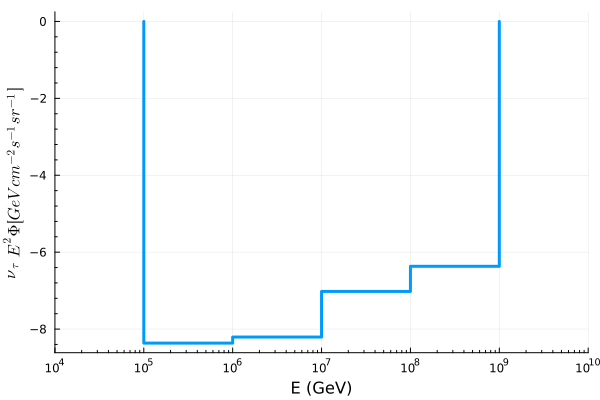

In [49]:
edges = 10 .^ (13:1:18)
cents = 10 .^ ((log10.(edges[1:end-1]) .+ log10.(edges[2:end])) / 2)
norm_factors = []

for (idx,edge) in enumerate(edges[1:end-1])
    # println("edge: ", edge)
    binned_events = filter(x-> x.initial_state.energy .> edges[idx] && x.initial_state.energy .< edges[idx+1], all_events)
    # println(length(binned_events))
    if length(binned_events) == 0
        continue
    end
    energies = [binned_events[i].initial_state.energy for i in 1:length(binned_events)]
    rates = diff_sens_calc(binned_events, energies, 1)
    norm_factor = 1 /  sum(rates * 1 * (22000/nmodules) * 10 * 10^7.5 * units.second)
    # println("norm_factors: ", norm_factor)
    push!(norm_factors,norm_factor)
    # println("rate: ", norm_factor * sum(rates * 1 * (22000/nmodules) * 10 * 10^7.5 * units.second))
    # println("rate: ", norm_factor * 1e-18)
end

diff_sens = 1e-18 .* norm_factors


plt = plot(
    xscale=:log,
    # yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\nu_{\\tau}\$ \$E^{2}\\Phi [GeV cm^{-2} s^{-1} sr^{-1}]\$",
    xlimits=(1e4, 1e10),
    #ylimits=(1e-20, 1e-8),
    legend=:topleft,
    size=(600, 400)   
)

edges = 10 .^ (14:1:18)
cents = 10 .^ ((log10.(edges[1:end-1]) .+ log10.(edges[2:end])) / 2)
#hist_three = fit(Histogram, unique(all_events["initial_state"]["energy"]), Weights((all_events["initial_state"]["energy"]).^2 .* (1.8e-18)), edges)

plot!(
    plt,
    edges / units.GeV,
    log.(10, (cents / units.GeV) .^ 2 .* diff_sens),
    # hist_three.weights .*norm_factors,
    linetype=:stepbins,
    label="",
    lw=3
    )

display(plt)

Effective Area Calculation 

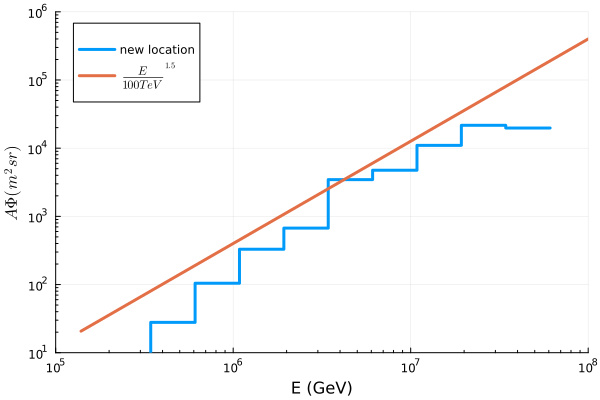

In [50]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ A\\Phi (m^{2}sr) \$",
    xlimits=(1e5, 1e8),
    ylimits=(1e1, 1e6),
    legend=:topleft,
    size=(600, 400)   
)

γ = 2.5
norm = 2.3e-18 / units.GeV / units.cm^2 / units.second * (1 /(100units.TeV))^-γ
pl = Tambo.PowerLaw(γ, 100units.GeV, 1e9units.GeV, norm)
fluxes = pl.(unique(all_events["initial_state"]["energy"]))
edges = 10 .^ (14:0.25:18)
cents = (edges[1:end-1] .+ edges[2:end]) / 2
wgts = oneweight.(all_events, Ref(injector), Ref(injector.xs)) ./ (config.n * length(files))

label = "Triggered Effective Areas"
hist_three = fit(Histogram, unique(all_events["initial_state"]["energy"]), Weights(wgts), edges)

plot!(
    plt,
    cents / units.GeV,
    hist_three.weights ./ diff(edges) ./units.m^2 * (22000/nmodules),
    linetype=:stepmid,
    label="new location",
    lw=3
    )


f(x) = 400 * (x/1e15)^1.5

# Generate the data points
y = f.(cents)     # Broadcast the function f over the array x
plot!(plt, cents/units.GeV,y,lw=3,label="\$ \\frac{E}{100TeV}^{1.5}\$")

display(plt)

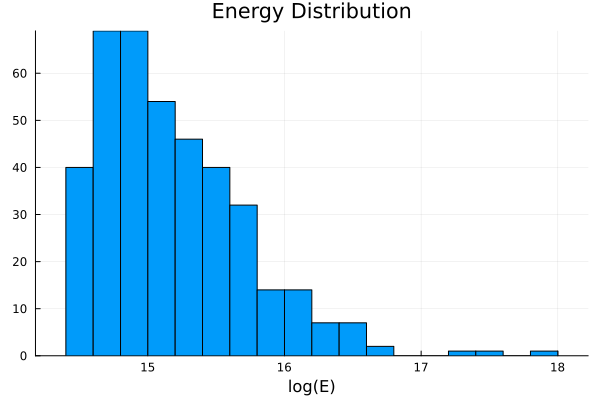

In [51]:
histogram(log10.(all_events["initial_state"]["energy"]),xlabel="log(E)",label="",title="Energy Distribution")

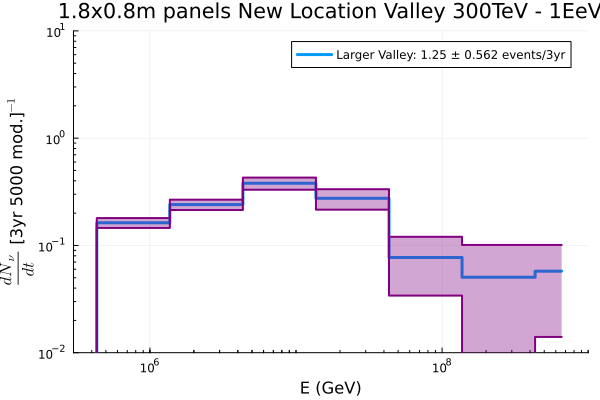

Bool[1, 1, 1, 1, 1, 1, 1, 1]
Any[3.9616345451823307e-28, 6.863314579657467e-27, 1.0591660440894139e-26, 1.9669914231537496e-26, 2.370010372571264e-26, 1.723919491145179e-26, 2.019903439235259e-26, 1.7408873858284878e-26]
[0.0016211882164454687, 0.14550747794624605, 0.21401283598052914, 0.33072914021599337, 0.21558665746356173, 0.03408930138886886, -1.4359758603081018e-17, 0.014040760036868757]


In [63]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\frac{dN_{\\nu}}{dt}\$ [3yr 5000 mod.]\$^{-1}\$",
    xlimits=(3e5, 1e9),
    ylimits=(1e-2, 1e1),
    legend=:topright,
    title= "1.8x0.8m panels New Location Valley 300TeV - 1EeV",
    size=(600, 400)   
)

edges = 10 .^ (14:0.5:18)
cents = (edges[1:end-1] .+ edges[2:end]) / 2

formatted_number = round(events_per_3years_5kdetectors,sigdigits=3)
hist_wp = fit(Histogram, all_events["initial_state"]["energy"], Weights(all_rates), edges)

mask = hist_wp.weights.>0
println(mask)
hist_wp.weights = hist_wp.weights[mask]
cents = cents[mask]
ugh = sqrt(sum((hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules)).^2))
ugh = round(ugh, sigdigits=3)
label = "Larger Valley: $(formatted_number) ± $(ugh) events/3yr"

errors = []
for (idx,edge) in enumerate(edges[1:end-1])
    # println("edge: ", edge)
    binned_events = filter(x-> x.initial_state.energy .> edges[idx] && x.initial_state.energy .< edges[idx+1], all_events)
    # println(length(binned_events))
    if length(binned_events) == 0
        continue
    end
    energies = [binned_events[i].initial_state.energy for i in 1:length(binned_events)]
    #1.8 to match the normalization from above 
    new_rates = diff_sens_calc(binned_events, energies, 2.52) *1.8 
    error = sqrt(sum(new_rates.^2))
    # println("norm_factors: ", norm_factor)
    push!(errors,error)
    # println("rate: ", norm_factor * sum(rates * 1 * (22000/nmodules) * 10 * 10^7.5 * units.second))
    # println("rate: ", norm_factor * 1e-18)
end

println(errors)

println((hist_wp.weights .- errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules))
label = "Larger Valley: $(formatted_number) ± $(ugh) events/3yr"
down = (hist_wp.weights .- errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules)
down[down .< 0] .= 1e-29

plot!(
    plt,
    cents / units.GeV,
    hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

plot!(
    plt, 
    cents / units.GeV,
    down,
    # (hist_wp.weights[1:end] .+ sqrt.(sum(hist_wp_error.weights[1:end]))) .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    fillrange = (hist_wp.weights .+ errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    fillalpha = 0.35, 
    linetype=:stepmid,
    linealpha= 0,
    label="",
    c = :purple
    )

plot!(
    plt, 
    cents / units.GeV,
    (hist_wp.weights .+ errors) .* units.second * 3*10^7.5 .* (5_000 / nmodules), 
    linetype=:stepmid,
    lw=2,
    label="",
    c = :purple
    )

plot!(
    plt, 
    cents / units.GeV,
    down,
    linetype=:stepmid,
    lw=2,
    label="",
    c = :purple
    )

display(plt)


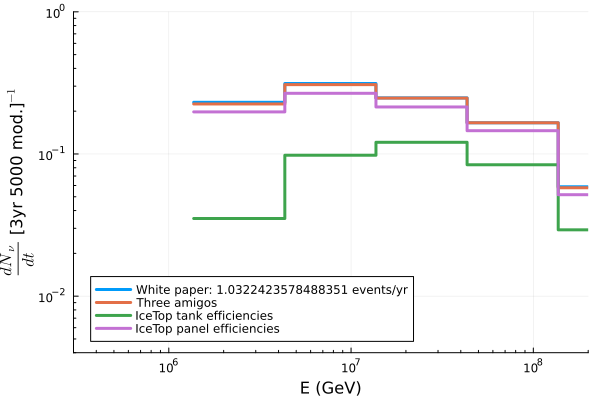

In [19]:
plt = plot(
    xscale=:log,
    yscale=:log,
    xlabel="E (GeV)",
    xminorticks=true,
    yminorticks=true,
    ylabel="\$ \\frac{dN_{\\nu}}{dt}\$ [3yr 5000 mod.]\$^{-1}\$",
    xlimits=(3e5, 2e8),
    ylimits=(4e-3, 1e0),
    legend=:bottomleft,
    size=(600, 400)   
)

nmodules = 400
edges = 10 .^ (14:0.5:18)
cents = (edges[1:end-1] .+ edges[2:end]) / 2

label = "White paper: $(events_per_year_wp) events/yr"
hist_wp = fit(Histogram, triggered_events_white_paper["initial_state"]["energy"], Weights(rates_white_paper), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_wp.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "Three amigos"
hist_three = fit(Histogram, triggered_events_three_amigos["initial_state"]["energy"], Weights(rates_three_amigos), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_three.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "IceTop tank efficiencies"
hist_it = fit(Histogram, triggered_events_icetop_tanks["initial_state"]["energy"], Weights(rates_icetop_tanks), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_it.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

label = "IceTop panel efficiencies"
hist_it = fit(Histogram, triggered_events_icetop_panels["initial_state"]["energy"], Weights(rates_icetop_panels), edges)
plot!(
    plt,
    cents / units.GeV,
    hist_it.weights .* units.second * 3*10^7.5 .* (5_000 / nmodules),
    linetype=:stepmid,
    label=label,
    lw=3
    )

display(plt)